# 主成分分析による教師なし次元削減
* d 次元のデータセットを標準化
* データセットの共分散行列を作成
* 共分散行列を固有ベクトルと固有値に分解
* 最も大きい k 個の固有値に対応する固有ベクトルを選択
* 射影行列 W を作成
* 射影行列 W で d 次元のデータセットを k 次元に変換

In [34]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 2列目以降のデータをXに、1列目のデータをyに
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

# 標準化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit(X_test)

In [36]:
import numpy as np
# 共分散行列を作成
cov_mat = np.cov(X_train_std.T)
# 固有値と固有ベクトルを計算
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.8923 2.4664 1.4281 1.0123 0.8491 0.6018 0.5225 0.0841 0.3305 0.296
 0.1683 0.2143 0.24  ]


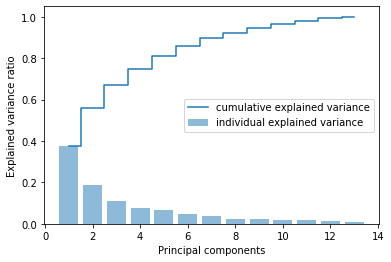

In [37]:
# 分散説明率をプロット
# 固有値を合計
tot = sum(eigen_vals)
# 分散説明率を計算
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 分散説明率の累積和を取得
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [0]:
# (固有値, 固有ベクトル)のタプルのリストを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# (固有値, 固有ベクトル)のタプルを大きいものから順に並び替え
eigen_pairs.sort(reverse=True)

In [39]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.1467  0.5042]
 [-0.2422  0.2422]
 [-0.0299  0.287 ]
 [-0.2552 -0.0647]
 [ 0.1208  0.23  ]
 [ 0.3893  0.0936]
 [ 0.4233  0.0109]
 [-0.3063  0.0187]
 [ 0.3057  0.0304]
 [-0.0987  0.5453]
 [ 0.3003 -0.2792]
 [ 0.3682 -0.1744]
 [ 0.2926  0.3632]]


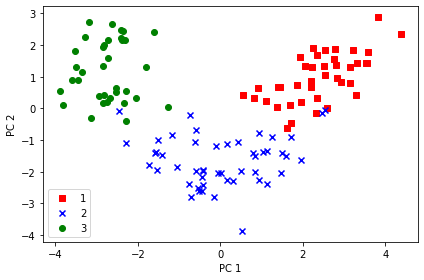

In [40]:
# 内積を求めて2次元データに変換
X_train_pca = X_train_std.dot(w)

# プロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
#X_test_pca = pca.transform(X_test_std)

In [0]:
# 決定領域をプロットする関数を作成
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # マーカーと色を準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 決定領域をプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 各クラスのサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


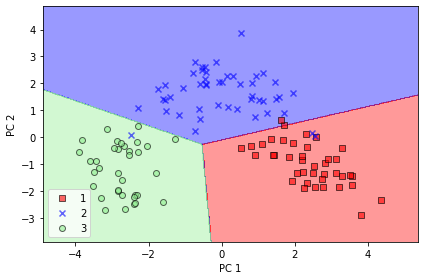

In [43]:
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰を学習
lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

# 決定領域をプロット
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 線形判別分類による教師ありデータ圧縮
Linear Discriminant Analysis: LDA
* d 次元のデータセットを標準化
* クラスごとに　d 次元の平均ベクトルを算出
* クラス間変動行列 S\_B とクラス内変動行列 S\_W を生成
* S\_W*S\_B の固有ベクトルと固有値を計算
* dxk 次元の変換行列 W を生成するため、最も大きい k 個の固有値に対応する k 個の固有ベクトルを選択
* 変換行列 W でサンプルを変換

In [44]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [45]:
d = 13  # 特徴量の数
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [46]:
# クラスラベルが一様に分布しているか確認
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [47]:
# 正規化された変動行列を算出
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
  class_scatter = np.cov(X_train_std[y_train==label].T)
  S_W += class_scatter

print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [48]:
# クラス間変動行列の計算
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
  n = X_train[y_train==i+1, :].shape[0]
  mean_vecs = mean_vec.reshape(d, 1)
  mean_overall = mean_overall.reshape(d, 1)
  S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [49]:
# inv 関数で逆行列、dot 関数で行列積、eig 関数で固有値を計算
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# 固有値を大きいものから降順で並び替える
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in  eigen_pairs:
  print(eigen_val[0])

5818.517655741973
9.026925513760635e-13
5.528689829604058e-13
5.528689829604058e-13
4.4223616490747444e-13
3.189317159308485e-13
3.189317159308485e-13
2.3377652178220244e-13
1.3249876266398904e-13
1.099616183882546e-13
1.099616183882546e-13
8.443760997059121e-14
0.0


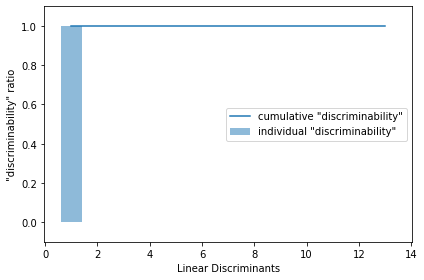

In [50]:
# 固有値の実数部の総和を求める
tot = sum(eigen_vals.real)
# 分散説明率とその累積話を計算
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [51]:
# 2つの固有ベクトルから変換行列を作成
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0712  0.0307]
 [-0.1504 -0.6103]
 [ 0.0709 -0.1417]
 [-0.0466  0.0626]
 [-0.151   0.0617]
 [ 0.2528 -0.3003]
 [-0.6676  0.5994]
 [-0.2561  0.2979]
 [ 0.1254 -0.2091]
 [-0.166   0.0974]
 [-0.1949  0.0538]
 [-0.4285  0.0661]
 [-0.3198 -0.0083]]


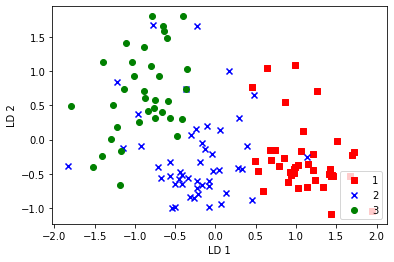

In [52]:
# 標準化したトレーニングデータに変換行列をかける
X_train_lda = X_train_std.dot(w)

# プロットする色、形を設定
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_lda[y_train==l, 0] * (-1), X_train_lda[y_train==l, 1] * (-1),
              c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

In [0]:
# scikit-learn で LDA を行う
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# 次元数を指定
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


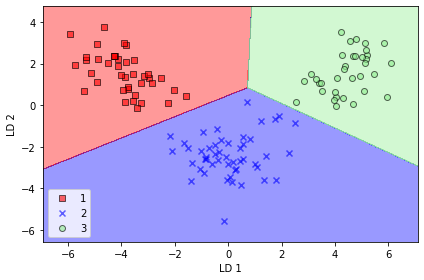

In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# カーネル主成分分析を使った非線形写像
PCA, LDA は線分離可能なデータ  
非線形には？ -> カーネルを用いた PCA

In [0]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
  """ RBF カーネル PCA の実装
  :param X: {Numpy ndarray}, shape=[n_samples, n_features]
  :param gamma: float, RBF カーネルのチューニングパラメータ
  :param n_components: int, 返される主成分の個数

  :return X_pc: {Numpy, ndarray}, shape=[n_samples, k_features]
  """

  # MxN 次元のデータセットでペアごとに平方ユークリッド距離を計算
  sq_dists = pdist(X, 'sqeuclidean')

  # ペアごとの距離を正方行列に変換
  mat_sq_dists = squareform(sq_dists)

  # 対象カーネル行列を計算
  K = exp(-gamma * mat_sq_dists)

  # カーネル行列を中心化
  N = K.shape[0]
  one_n = np.ones((N, N)) / N
  K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

  # 中心化されたカーネル行列から固有対を取得
  # numpy.eigh はそれらをソート順に返す
  eigvals, eigvecs = eigh(K)

  # 上位 k 個の固有ベクトル(射影されたサンプル)を収集
  X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))

  return X_pc

## 半月形のデータを分離

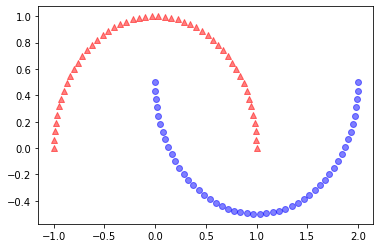

In [56]:
# 半月形のデータを作成してプロット
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

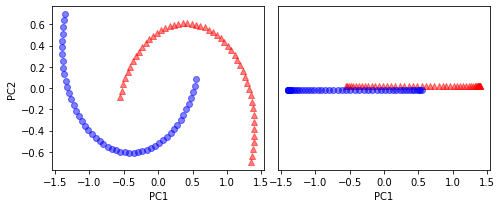

In [57]:
# これまで通りの PCA を使って主成分に射影したらどうなる？
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
# プロット
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


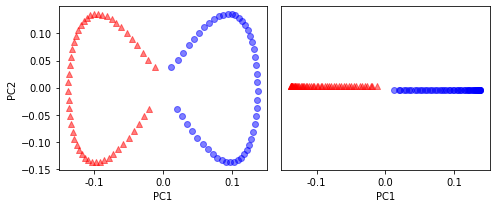

In [58]:
from matplotlib.ticker import FormatStrFormatter

# カーネル PCA を実行
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# プロット
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.tight_layout()
plt.show()

## 同心円のデータを分離

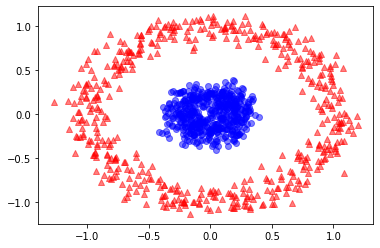

In [59]:
# 同心円のデータを作成
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)

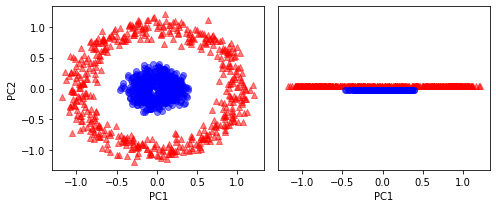

In [60]:
# これまで通りの PCA だとどうなる？
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


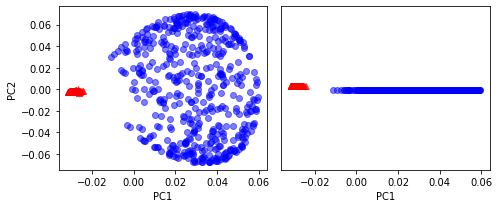

In [62]:
# カーネル PCA を実行
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

# 新しいデータ点を写像する

In [0]:
# 新しいデータを獲得した後、固有ベクトルを正規化する必要がある
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i]
                              for i in range(1, n_components + 1)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]

    return alphas, lambdas

In [64]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [67]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [68]:
x_proj = alphas[25]
x_proj

array([0.0788])

In [0]:
def project_x(x_new, X, gamma, alphas, lambdas):
  pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
  k = np.exp(-gamma * pair_dist)
  return k.dot(alphas / lambdas)

In [70]:
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.0788])

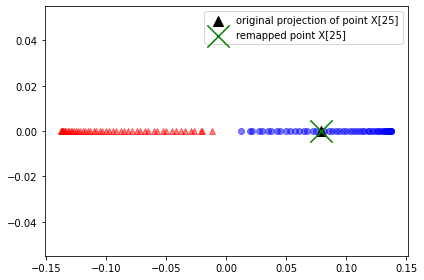

In [71]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'PC2')

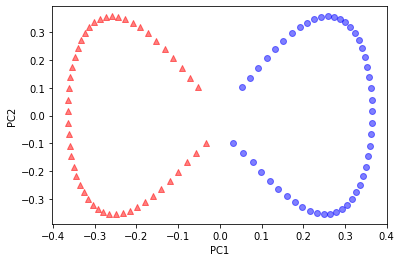

In [72]:
# scikit-learn のカーネル主成分分析を用いる
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')